In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [2]:
dataset_folder = "dataset/cleaned"
sensor_name = "Sensor 3"
save_folder = f"saved_model/{sensor_name}"

In [3]:
train_data = pd.read_csv(
    f"{dataset_folder}/train/{sensor_name}_train.csv"
)
val_data = pd.read_csv(
    f"{dataset_folder}/val/{sensor_name}_val.csv"
)
test_data = pd.read_csv(
    f"{dataset_folder}/test/{sensor_name}_test.csv"
)

train_data["created_at"] = pd.to_datetime(train_data["created_at"], format="ISO8601")
val_data["created_at"] = pd.to_datetime(val_data["created_at"], format="ISO8601")
test_data["created_at"] = pd.to_datetime(test_data["created_at"], format="ISO8601")

train_data.set_index("created_at", inplace=True)
val_data.set_index("created_at", inplace=True)
test_data.set_index("created_at", inplace=True)

In [4]:
train_data = train_data[['power']]
val_data = val_data[['power']]
test_data = test_data[['power']]

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [6]:
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [7]:
X_train, y_train = create_sequences(train_data_scaled, time_steps=24)
X_val, y_val = create_sequences(val_data_scaled, time_steps=24)
X_test, y_test = create_sequences(test_data_scaled, time_steps=24)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [8]:
# Define the LSTM model with modifications
model = Sequential()

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1))))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Additional LSTM Layer
model.add(LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Final LSTM Layer
model.add(LSTM(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(1))

# Compile the model with learning rate scheduler
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error')

d:\Daffa Titip\power-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=32, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 677s 31ms/step - loss: 0.4257 - val_loss: 0.0019 - learning_rate: 1.0409e-04
Epoch 2/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 681s 32ms/step - loss: 4.6543e-04 - val_loss: 6.0462e-04 - learning_rate: 1.0834e-05
Epoch 3/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 694s 32ms/step - loss: 4.1799e-04 - val_loss: 4.5992e-04 - learning_rate: 1.1277e-06
Epoch 4/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 695s 32ms/step - loss: 4.1022e-04 - val_loss: 3.4628e-04 - learning_rate: 1.1739e-07
Epoch 5/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 694s 32ms/step - loss: 4.0603e-04 - val_loss: 3.3896e-04 - learning_rate: 1.2218e-08
Epoch 6/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 703s 33ms/step - loss: 4.0995e-04 - val_loss: 3.3919e-04 - learning_rate: 1.2718e-09
Epoch 7/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 710s 33ms/step - loss: 4.1500e-04 - val_loss: 3.3924e-04 - learning_rate: 1.3238e-10
Epoch 8/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 704s 33ms/step - loss: 4.0892e-04 - val_loss: 3.3450e-04 - le

In [10]:
model.export(save_folder)

INFO:tensorflow:Assets written to: saved_model/Sensor 3\assets


INFO:tensorflow:Assets written to: saved_model/Sensor 3\assets


Saved artifact at 'saved_model/Sensor 3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1871187590032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1871187590992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1872755066832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1872755067600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1872755068176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1872755070096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1872755071440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1872755071824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1872755070672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1872755071056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1872755069712: TensorSpec(shape=(), 

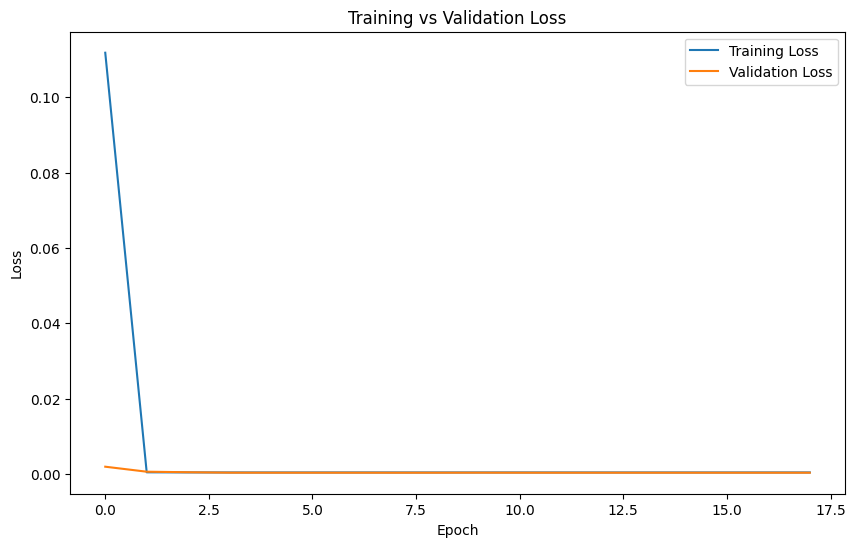

In [11]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
y_pred = model.predict(X_test)

10181/10181 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step


In [13]:
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

In [14]:
print("Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

Performance Metrics:
Mean Absolute Error (MAE): 1.82
Mean Squared Error (MSE): 8.89
Root Mean Squared Error (RMSE): 2.98
R² Score: 0.992


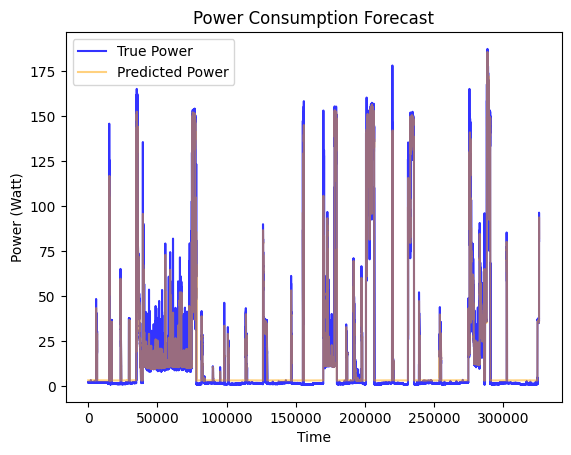

In [15]:
plt.plot(y_test_rescaled, label='True Power', color='blue', alpha=0.8)
plt.plot(y_pred_rescaled, label='Predicted Power', color='orange', alpha=0.5)
plt.legend()
plt.title("Power Consumption Forecast")
plt.xlabel("Time")
plt.ylabel("Power (Watt)")
plt.show()

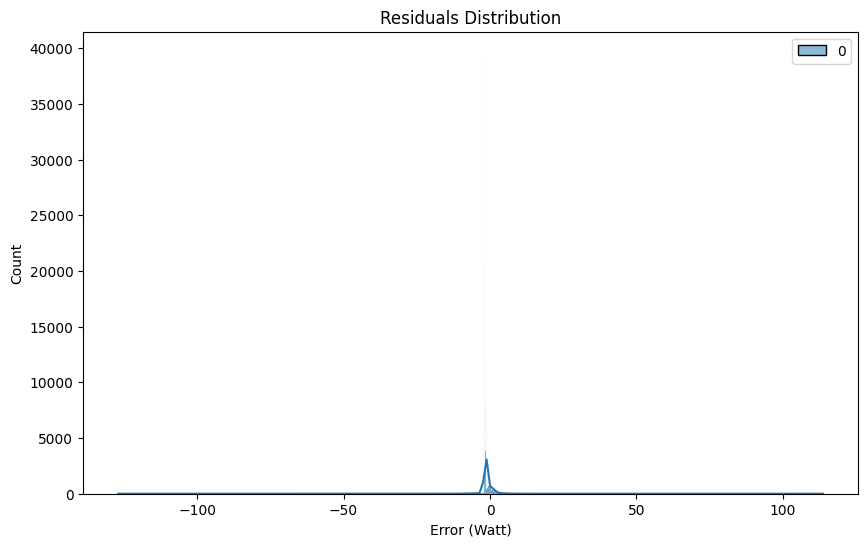

In [16]:
residuals = y_test_rescaled - y_pred_rescaled

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Error (Watt)')
plt.show()

In [17]:
result_df = pd.DataFrame({
    'time': test_data.index[24:].strftime('%Y-%m-%dT%H:%M:%S'),
    'predicted_power': y_pred_rescaled.flatten(),
    'actual_power': y_test_rescaled.flatten(),
})

In [18]:
result_df['time'] = pd.to_datetime(result_df['time'], format="ISO8601")
result_df['date'] = result_df['time'].dt.date
daily_counts = result_df.groupby(['date']).size().reset_index(name='count')
daily_counts["date"] = daily_counts["date"].astype(str)

dates = []
predicted_energy = []
actual_energy = []
different = []

for _, row in daily_counts.iterrows():
    date = row["date"]
    
    sensor_data = result_df[result_df["date"] == pd.to_datetime(date).date()]
    sensor_data = sensor_data.sort_values(by="time")
    
    sensor_data["time_diff"] = sensor_data["time"].diff().dt.total_seconds()
    average_interval = sensor_data["time_diff"].mean()
    
    total_energy_predicted = 0
    total_energy_actual = 0
    for _, row in sensor_data.iterrows():
        predicted_power = row["predicted_power"]
        actual_power = row["actual_power"]
        interval = average_interval / 3600

        predicted_energy_value = (predicted_power * interval) / 1000
        total_energy_predicted += predicted_energy_value

        actual_energy_value = (actual_power * interval) / 1000
        total_energy_actual += actual_energy_value

    dates.append(date)
    predicted_energy.append(total_energy_predicted)
    actual_energy.append(total_energy_actual)
    different.append(total_energy_actual - total_energy_predicted)

    print(f"Different energy consumption ({date}):", total_energy_actual - total_energy_predicted, "kWh")

Different energy consumption (2024-11-10): -0.03247129790177118 kWh
Different energy consumption (2024-11-11): -0.004044133602848221 kWh
Different energy consumption (2024-11-12): -0.003496658943263009 kWh
Different energy consumption (2024-11-13): -0.03856143859810601 kWh
Different energy consumption (2024-11-14): -0.03126556508353695 kWh
Different energy consumption (2024-11-15): -0.03947580063431412 kWh
Different energy consumption (2024-11-16): -0.024553337365081362 kWh
Different energy consumption (2024-11-17): -0.03078208539777605 kWh
Different energy consumption (2024-11-18): -0.03486004932313902 kWh
Different energy consumption (2024-11-19): -0.03602788237133869 kWh
Different energy consumption (2024-11-20): -0.015272783030643944 kWh
Different energy consumption (2024-11-21): -0.03774964399308252 kWh


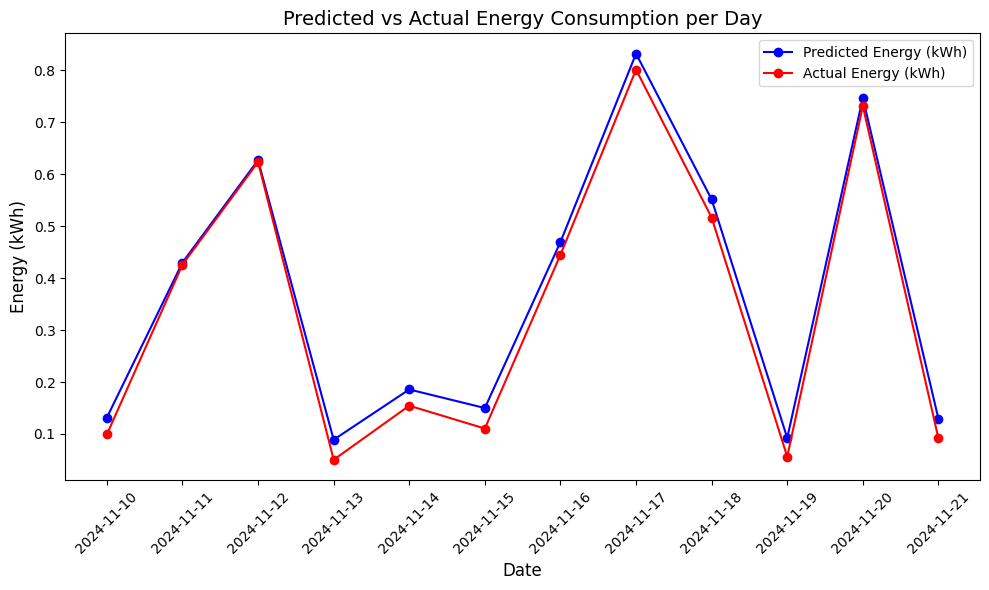

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(dates, predicted_energy, label="Predicted Energy (kWh)", marker='o', linestyle='-', color='blue')
plt.plot(dates, actual_energy, label="Actual Energy (kWh)", marker='o', linestyle='-', color='red')
plt.title("Predicted vs Actual Energy Consumption per Day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

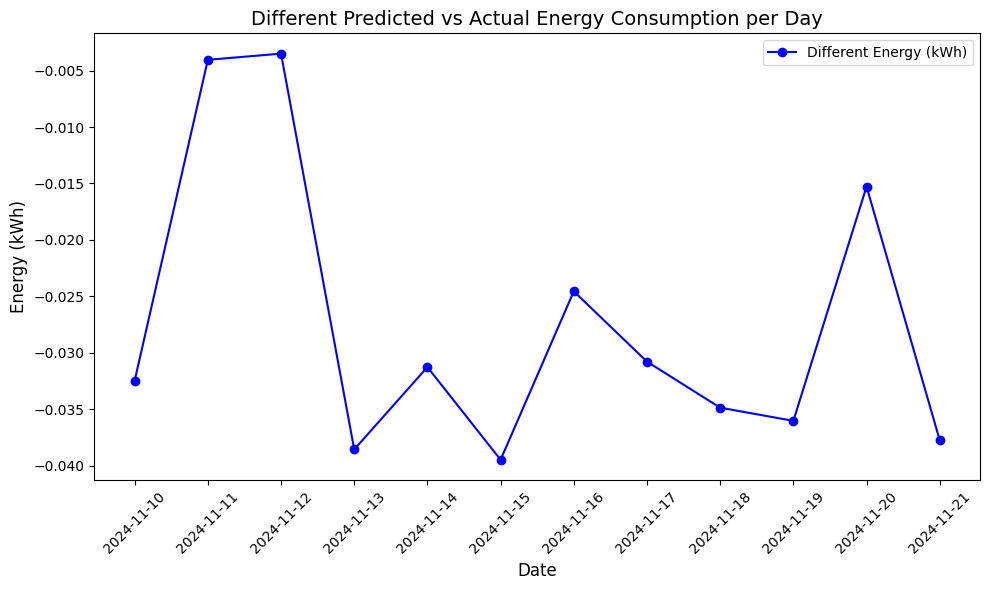

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(dates, different, label="Different Energy (kWh)", marker='o', linestyle='-', color='blue')
plt.title("Different Predicted vs Actual Energy Consumption per Day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()